<a href="https://colab.research.google.com/github/sabeesh90/Layer_Fine_Tuning_Deep_Neural_Networks/blob/main/The_Lazarus_Trials_NasNet_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


     |████████████████████████████████| 97 kB 3.4 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
pip install Ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab Notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks


In [ ]:
classes = ['GALAXY', 'QSO', 'STAR']

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

class Metrics:
    # from sklearn
    def __init__(self, model, val_ds):
        self.val_ds = val_ds
        self.model = model
        self.prediction_classes = np.array([])
        self.true_classes = np.array([])
        
    def calculate_scores(self):     
        print('calculating score.....')   
        
        for x, y in self.val_ds:
            self.prediction_classes = np.concatenate([self.prediction_classes,np.argmax(self.model.predict(x), axis = -1)])
            self.true_classes = np.concatenate([self.true_classes, np.argmax(y.numpy(), axis=-1)])
        
        class_report = classification_report(self.true_classes, self.prediction_classes)
        conf_matrix = confusion_matrix(self.true_classes, self.prediction_classes)
        print(conf_matrix)
        print('------------------------------------')
        print(class_report)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

#### Densenet 121

##### Data preparation

In [ ]:
# Preprocessing the data
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 8


img_width_crop = 1024
img_height_crop = 1024

rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

rescale_resize = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255),
                                      layers.experimental.preprocessing.Resizing(224,224)]) 


# augmenting the data
# cropless flip and rotate

data_aug_flip = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                # layers.experimental.preprocessing.RandomRotation(0.2)])
])

data_aug_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                layers.experimental.preprocessing.RandomRotation(0.2)])


# crop flip and rotate
data_aug_crop_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                                 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                                 layers.experimental.preprocessing.RandomRotation(0.2)])

data_aug_crop_flip = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

normal_crop = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512)],)
batch_size =32 
autotune = tf.data.AUTOTUNE

# Preparing the normal dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width_crop, img_height_crop), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width_crop, img_height_crop),
                                                                batch_size = batch_size, label_mode = 'categorical')


# preparing the scalred dataset
train_ds_scaled = train_ds.map(lambda x,y: (rescale_resize(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled = val_ds.map(lambda x,y: (rescale_resize(x, training = False), y), num_parallel_calls=autotune)
train_ds.prefetch(buffer_size=autotune)
val_ds.prefetch(buffer_size=autotune)

train_ds_scaled_cropped = train_ds_scaled.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled_cropped = val_ds_scaled.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)

# augment function 
def prepare_dataset(ds, flip = False, flip_rotate = False):
    if flip == True:
        ds = ds.map(lambda x, y : (data_aug_flip(x, training = True), y), num_parallel_calls = autotune)
    elif flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)

def prepare_dataset_crop(ds, crop_flip = False, crop_flip_rotate = False):
    if crop_flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    elif crop_flip == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)
    
def prepare_dataset_normal_crop(ds, training = True):
    ds = ds.map(lambda x, y : (normal_crop(x, training = training), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
# 25 batches of 32 each and 7 batches of 32 each



Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


##### Densenet model building

In [ ]:
from tensorflow.keras.applications import  NASNetMobile
models = {'base_model'+str(num) : NASNetMobile(include_top=False, weights='imagenet', 
                                           input_shape = (224, 224, 3),classes = num_classes, pooling = 'avg') for num in range(0,10)}

In [ ]:
models

{'base_model0': <keras.engine.functional.Functional at 0x7f0c90200090>,
 'base_model1': <keras.engine.functional.Functional at 0x7f0c90265b50>,
 'base_model2': <keras.engine.functional.Functional at 0x7f0c8f71ef90>,
 'base_model3': <keras.engine.functional.Functional at 0x7f0c8e26bbd0>,
 'base_model4': <keras.engine.functional.Functional at 0x7f0c8e275b90>,
 'base_model5': <keras.engine.functional.Functional at 0x7f0c8cc48810>,
 'base_model6': <keras.engine.functional.Functional at 0x7f0c8c191490>,
 'base_model7': <keras.engine.functional.Functional at 0x7f0c8c71b210>,
 'base_model8': <keras.engine.functional.Functional at 0x7f0c8aca91d0>,
 'base_model9': <keras.engine.functional.Functional at 0x7f0c8a21fcd0>}

In [ ]:
layer_count  = len(models['base_model0'].layers)
print(f'There are a total of {layer_count} in the Densenet layer')

There are a total of 770 in the Densenet layer


In [ ]:
for model,value in models.items():
    print(model)

base_model0
base_model1
base_model2
base_model3
base_model4
base_model5
base_model6
base_model7
base_model8
base_model9


In [ ]:
num=0
for i, (model_name, model) in zip(range(770, -1,-10), models.items()):
    break_point  = i
    for layer in model.layers[0:break_point]:
        layer.trainable = False
    for layer in model.layers[break_point:]:
        layer.trainable = True
    input_layer = model.input
    output_layer = model.output
    x = Dense(num_classes, activation  = 'softmax')(output_layer)    
    models[model_name] = Model(inputs = input_layer, outputs = x)


In [ ]:
for model_name, model in models.items():
    count = 0
    trained_layers = ['a' if layer.trainable == True else None for layer in model.layers]
    print(f'The number of trainable layers in {model_name} is', trained_layers.count('a'), sep=':')

The number of trainable layers in base_model0 is:1
The number of trainable layers in base_model1 is:11
The number of trainable layers in base_model2 is:21
The number of trainable layers in base_model3 is:31
The number of trainable layers in base_model4 is:41
The number of trainable layers in base_model5 is:51
The number of trainable layers in base_model6 is:61
The number of trainable layers in base_model7 is:71
The number of trainable layers in base_model8 is:81
The number of trainable layers in base_model9 is:91


In [ ]:
# resnet_model.summary()
for model_name, model in models.items():
    model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

##### Densnet model with normalization of  image pixels

In [ ]:
models['base_model0'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 144s 4s/step - loss: 1.6591 - accuracy: 0.1863 - val_loss: 1.2101 - val_accuracy: 0.2550
Epoch 2/60
25/25 [==============================] - 17s 533ms/step - loss: 1.5311 - accuracy: 0.3800 - val_loss: 1.0930 - val_accuracy: 0.3250
Epoch 3/60
25/25 [==============================] - 18s 601ms/step - loss: 1.4653 - accuracy: 0.5038 - val_loss: 1.0373 - val_accuracy: 0.3850
Epoch 4/60
25/25 [==============================] - 17s 534ms/step - loss: 1.4121 - accuracy: 0.5650 - val_loss: 1.0051 - val_accuracy: 0.4600
Epoch 5/60
25/25 [==============================] - 17s 534ms/step - loss: 1.3616 - accuracy: 0.6100 - val_loss: 0.9694 - val_accuracy: 0.5050
Epoch 6/60
25/25 [==============================] - 17s 540ms/step - loss: 1.3163 - accuracy: 0.6500 - val_loss: 0.9464 - val_accuracy: 0.5650
Epoch 7/60
25/25 [==============================] - 18s 596ms/step - loss: 1.2750 - accuracy: 0.6775 - val_loss: 0.9184 - val_accuracy: 0.6150
E

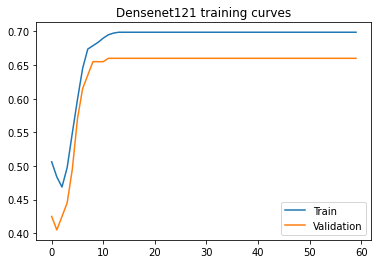

In [ ]:
plt.plot(models['base_model0'].history.history['accuracy'])
plt.plot(models['base_model0'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 37s 772ms/step - loss: 1.5922 - accuracy: 0.4875 - val_loss: 0.9826 - val_accuracy: 0.5250
Epoch 2/60
25/25 [==============================] - 17s 542ms/step - loss: 1.4864 - accuracy: 0.5188 - val_loss: 0.9771 - val_accuracy: 0.5750
Epoch 3/60
25/25 [==============================] - 19s 609ms/step - loss: 1.4292 - accuracy: 0.5713 - val_loss: 0.9512 - val_accuracy: 0.6450
Epoch 4/60
25/25 [==============================] - 19s 613ms/step - loss: 1.3797 - accuracy: 0.5888 - val_loss: 0.9155 - val_accuracy: 0.6800
Epoch 5/60
25/25 [==============================] - 17s 544ms/step - loss: 1.3318 - accuracy: 0.6388 - val_loss: 0.8871 - val_accuracy: 0.6950
Epoch 6/60
25/25 [==============================] - 17s 540ms/step - loss: 1.2915 - accuracy: 0.6488 - val_loss: 0.8640 - val_accuracy: 0.7250
Epoch 7/60
25/25 [==============================] - 18s 603ms/step - loss: 1.2516 - accuracy: 0.6862 - val_loss: 0.8411 - val_accuracy: 0.7300

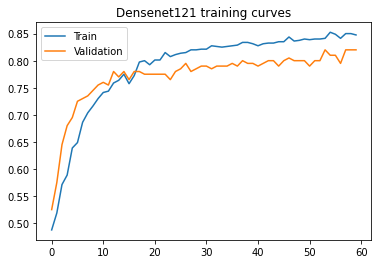

In [ ]:
models['base_model1'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model1'].history.history['accuracy'])
plt.plot(models['base_model1'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 38s 807ms/step - loss: 1.5361 - accuracy: 0.4387 - val_loss: 1.0111 - val_accuracy: 0.4850
Epoch 2/60
25/25 [==============================] - 17s 540ms/step - loss: 1.2625 - accuracy: 0.6500 - val_loss: 0.9164 - val_accuracy: 0.5600
Epoch 3/60
25/25 [==============================] - 18s 603ms/step - loss: 1.0954 - accuracy: 0.7163 - val_loss: 0.8591 - val_accuracy: 0.5750
Epoch 4/60
25/25 [==============================] - 17s 535ms/step - loss: 0.9615 - accuracy: 0.7738 - val_loss: 0.7994 - val_accuracy: 0.6250
Epoch 5/60
25/25 [==============================] - 17s 538ms/step - loss: 0.8808 - accuracy: 0.7975 - val_loss: 0.7685 - val_accuracy: 0.6250
Epoch 6/60
25/25 [==============================] - 18s 603ms/step - loss: 0.8151 - accuracy: 0.8288 - val_loss: 0.7303 - val_accuracy: 0.6400
Epoch 7/60
25/25 [==============================] - 18s 600ms/step - loss: 0.7473 - accuracy: 0.8338 - val_loss: 0.7095 - val_accuracy: 0.6500

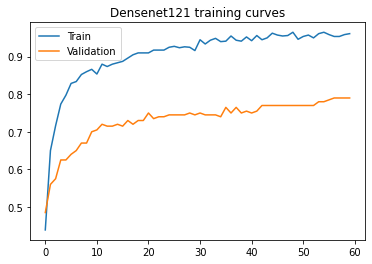

In [ ]:
models['base_model2'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model2'].history.history['accuracy'])
plt.plot(models['base_model2'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 36s 725ms/step - loss: 1.4151 - accuracy: 0.5750 - val_loss: 0.9582 - val_accuracy: 0.5700
Epoch 2/60
25/25 [==============================] - 17s 535ms/step - loss: 1.0928 - accuracy: 0.7525 - val_loss: 0.8801 - val_accuracy: 0.6300
Epoch 3/60
25/25 [==============================] - 18s 598ms/step - loss: 0.9168 - accuracy: 0.7925 - val_loss: 0.8298 - val_accuracy: 0.6200
Epoch 4/60
25/25 [==============================] - 17s 533ms/step - loss: 0.8125 - accuracy: 0.8438 - val_loss: 0.7701 - val_accuracy: 0.6450
Epoch 5/60
25/25 [==============================] - 18s 597ms/step - loss: 0.7210 - accuracy: 0.8475 - val_loss: 0.7698 - val_accuracy: 0.6350
Epoch 6/60
25/25 [==============================] - 18s 598ms/step - loss: 0.6787 - accuracy: 0.8425 - val_loss: 0.7226 - val_accuracy: 0.6550
Epoch 7/60
25/25 [==============================] - 17s 536ms/step - loss: 0.6339 - accuracy: 0.8725 - val_loss: 0.6892 - val_accuracy: 0.6800

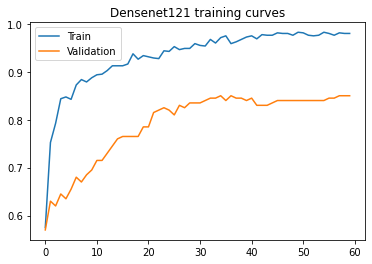

In [ ]:
models['base_model3'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model3'].history.history['accuracy'])
plt.plot(models['base_model3'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 35s 702ms/step - loss: 1.3662 - accuracy: 0.6700 - val_loss: 0.9940 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 18s 603ms/step - loss: 0.9044 - accuracy: 0.7812 - val_loss: 0.7857 - val_accuracy: 0.7050
Epoch 3/60
25/25 [==============================] - 18s 602ms/step - loss: 0.7179 - accuracy: 0.8537 - val_loss: 0.6644 - val_accuracy: 0.8000
Epoch 4/60
25/25 [==============================] - 18s 606ms/step - loss: 0.5951 - accuracy: 0.8850 - val_loss: 0.5649 - val_accuracy: 0.8400
Epoch 5/60
25/25 [==============================] - 18s 604ms/step - loss: 0.4955 - accuracy: 0.8913 - val_loss: 0.5192 - val_accuracy: 0.8450
Epoch 6/60
25/25 [==============================] - 18s 602ms/step - loss: 0.4273 - accuracy: 0.9038 - val_loss: 0.4796 - val_accuracy: 0.8400
Epoch 7/60
25/25 [==============================] - 17s 538ms/step - loss: 0.3998 - accuracy: 0.9038 - val_loss: 0.4550 - val_accuracy: 0.8400

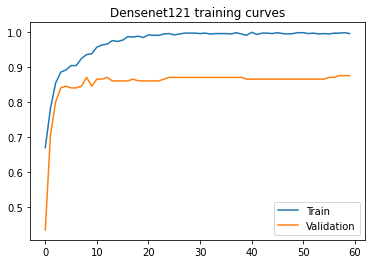

In [ ]:
models['base_model4'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model4'].history.history['accuracy'])
plt.plot(models['base_model4'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 40s 785ms/step - loss: 1.4982 - accuracy: 0.4762 - val_loss: 0.8718 - val_accuracy: 0.5150
Epoch 2/60
25/25 [==============================] - 17s 540ms/step - loss: 1.0813 - accuracy: 0.7638 - val_loss: 0.7897 - val_accuracy: 0.6600
Epoch 3/60
25/25 [==============================] - 18s 608ms/step - loss: 0.8006 - accuracy: 0.8338 - val_loss: 0.6874 - val_accuracy: 0.7500
Epoch 4/60
25/25 [==============================] - 18s 607ms/step - loss: 0.6096 - accuracy: 0.8525 - val_loss: 0.6201 - val_accuracy: 0.8200
Epoch 5/60
25/25 [==============================] - 18s 604ms/step - loss: 0.5172 - accuracy: 0.8750 - val_loss: 0.6028 - val_accuracy: 0.8100
Epoch 6/60
25/25 [==============================] - 19s 613ms/step - loss: 0.4280 - accuracy: 0.8825 - val_loss: 0.5617 - val_accuracy: 0.8450
Epoch 7/60
25/25 [==============================] - 17s 537ms/step - loss: 0.3674 - accuracy: 0.9162 - val_loss: 0.5669 - val_accuracy: 0.8350

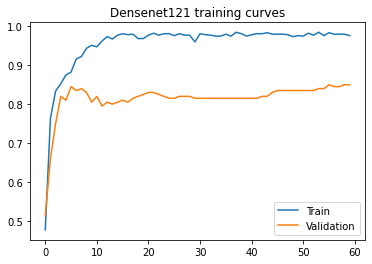

In [ ]:
models['base_model5'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model5'].history.history['accuracy'])
plt.plot(models['base_model5'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 37s 727ms/step - loss: 1.3932 - accuracy: 0.5537 - val_loss: 1.0088 - val_accuracy: 0.4750
Epoch 2/60
25/25 [==============================] - 19s 608ms/step - loss: 1.0306 - accuracy: 0.7663 - val_loss: 0.8573 - val_accuracy: 0.5550
Epoch 3/60
25/25 [==============================] - 17s 554ms/step - loss: 0.8023 - accuracy: 0.8225 - val_loss: 0.7364 - val_accuracy: 0.6700
Epoch 4/60
25/25 [==============================] - 17s 553ms/step - loss: 0.6296 - accuracy: 0.8425 - val_loss: 0.6752 - val_accuracy: 0.7550
Epoch 5/60
25/25 [==============================] - 17s 551ms/step - loss: 0.5253 - accuracy: 0.8900 - val_loss: 0.6395 - val_accuracy: 0.8250
Epoch 6/60
25/25 [==============================] - 19s 610ms/step - loss: 0.4800 - accuracy: 0.8763 - val_loss: 0.6278 - val_accuracy: 0.8250
Epoch 7/60
25/25 [==============================] - 17s 549ms/step - loss: 0.4095 - accuracy: 0.9137 - val_loss: 0.6206 - val_accuracy: 0.8450

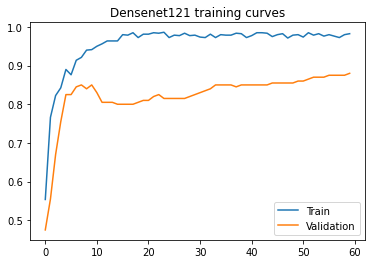

In [ ]:
models['base_model6'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model6'].history.history['accuracy'])
plt.plot(models['base_model6'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 37s 732ms/step - loss: 1.3557 - accuracy: 0.4900 - val_loss: 1.1581 - val_accuracy: 0.2500
Epoch 2/60
25/25 [==============================] - 17s 558ms/step - loss: 0.9450 - accuracy: 0.7663 - val_loss: 1.0104 - val_accuracy: 0.5100
Epoch 3/60
25/25 [==============================] - 19s 615ms/step - loss: 0.7060 - accuracy: 0.8625 - val_loss: 0.8533 - val_accuracy: 0.6000
Epoch 4/60
25/25 [==============================] - 19s 615ms/step - loss: 0.5645 - accuracy: 0.8712 - val_loss: 0.7919 - val_accuracy: 0.6350
Epoch 5/60
25/25 [==============================] - 19s 620ms/step - loss: 0.4796 - accuracy: 0.8838 - val_loss: 0.7592 - val_accuracy: 0.6700
Epoch 6/60
25/25 [==============================] - 19s 620ms/step - loss: 0.4010 - accuracy: 0.9038 - val_loss: 0.7275 - val_accuracy: 0.6700
Epoch 7/60
25/25 [==============================] - 19s 614ms/step - loss: 0.3149 - accuracy: 0.9300 - val_loss: 0.6903 - val_accuracy: 0.6950

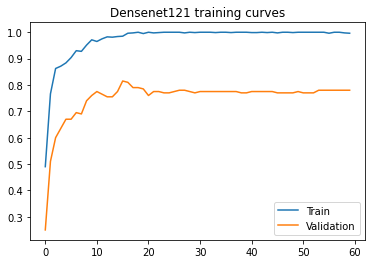

In [ ]:
models['base_model7'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model7'].history.history['accuracy'])
plt.plot(models['base_model7'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 39s 729ms/step - loss: 1.3817 - accuracy: 0.5888 - val_loss: 1.3530 - val_accuracy: 0.4250
Epoch 2/60
25/25 [==============================] - 19s 618ms/step - loss: 0.9209 - accuracy: 0.7738 - val_loss: 1.1810 - val_accuracy: 0.5250
Epoch 3/60
25/25 [==============================] - 19s 615ms/step - loss: 0.6309 - accuracy: 0.8825 - val_loss: 1.0255 - val_accuracy: 0.5450
Epoch 4/60
25/25 [==============================] - 19s 618ms/step - loss: 0.4785 - accuracy: 0.9013 - val_loss: 0.9024 - val_accuracy: 0.5800
Epoch 5/60
25/25 [==============================] - 19s 626ms/step - loss: 0.3614 - accuracy: 0.9200 - val_loss: 0.8064 - val_accuracy: 0.6200
Epoch 6/60
25/25 [==============================] - 18s 562ms/step - loss: 0.3000 - accuracy: 0.9400 - val_loss: 0.7068 - val_accuracy: 0.6900
Epoch 7/60
25/25 [==============================] - 19s 622ms/step - loss: 0.2183 - accuracy: 0.9488 - val_loss: 0.6323 - val_accuracy: 0.7750

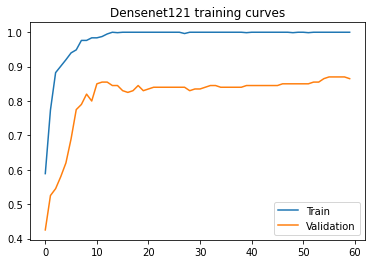

In [ ]:
models['base_model8'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model8'].history.history['accuracy'])
plt.plot(models['base_model8'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 39s 801ms/step - loss: 1.4982 - accuracy: 0.5150 - val_loss: 1.4453 - val_accuracy: 0.1150
Epoch 2/60
25/25 [==============================] - 17s 556ms/step - loss: 1.0487 - accuracy: 0.7387 - val_loss: 1.4513 - val_accuracy: 0.0900
Epoch 3/60
25/25 [==============================] - 19s 618ms/step - loss: 0.7007 - accuracy: 0.8350 - val_loss: 1.3984 - val_accuracy: 0.0950
Epoch 4/60
25/25 [==============================] - 17s 558ms/step - loss: 0.5030 - accuracy: 0.8975 - val_loss: 1.3439 - val_accuracy: 0.1100
Epoch 5/60
25/25 [==============================] - 19s 617ms/step - loss: 0.4290 - accuracy: 0.9000 - val_loss: 1.3544 - val_accuracy: 0.1050
Epoch 6/60
25/25 [==============================] - 17s 554ms/step - loss: 0.3490 - accuracy: 0.9112 - val_loss: 1.3375 - val_accuracy: 0.1100
Epoch 7/60
25/25 [==============================] - 19s 615ms/step - loss: 0.2519 - accuracy: 0.9400 - val_loss: 1.3037 - val_accuracy: 0.1150

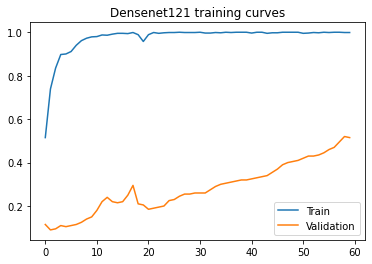

In [ ]:
models['base_model9'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model9'].history.history['accuracy'])
plt.plot(models['base_model9'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

In [ ]:
i=0
for model_name, model in models.items():
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('base_model'+str(i),trainableParams,nonTrainableParams,totalParams)
    i+=1


base_model0 3171 4269716 4272887
base_model1 3523 4269364 4272887
base_model2 137987 4134900 4272887
base_model3 174771 4098116 4272887
base_model4 343555 3929332 4272887
base_model5 715971 3556916 4272887
base_model6 717379 3555508 4272887
base_model7 886163 3386724 4272887
base_model8 1020979 3251908 4272887
base_model9 1428771 2844116 4272887
